In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import kagglehub

# Download dataset
path = kagglehub.dataset_download("vitaminc/cigarette-smoker-detection")
print("Downloaded to:", path)


import shutil

# Destination folder in Google Drive
gdrive_path = "/content/drive/MyDrive/data/cigarette-smoker-detection"

# Copy everything
shutil.copytree(path, gdrive_path, dirs_exist_ok=True)

print("Dataset saved to Google Drive at:", gdrive_path)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from PIL import Image
import random
import glob
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, Input,BatchNormalization,Dropout,Dense, Input,MaxPooling2D,Conv2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


## modifing images

In [ ]:
# drive.mount('/content/drive')

# # Specify the directory path
# directory_path_smoking = '/content/drive/My Drive/data/cigarette-smoker-detection/data/data/smoking'
# directory_path_not_smoking = '/content/drive/My Drive/data/cigarette-smoker-detection/data/data/not_smoking'

# # Get all files in the directory
# files = glob.glob(directory_path_smoking + '/*')
# img_height = 256
# img_width = 256
# i = 0
# for a in files:
#     file_name, file_extension = os.path.splitext(a)
#     i+=1
#     if file_extension.lower() != '.gif':
#       image = cv2.imread(a)
#       image = cv2.resize(image, (img_width,img_height))
#       cv2.imwrite(f'/content/drive/My Drive/data/cigarette-smoker-detection/data/data/resizedImage256Smoking/{i}'+file_extension, image)

# i = 0
# files = glob.glob(directory_path_not_smoking + '/*')

# for a in files:
#     file_name, file_extension = os.path.splitext(a)
#     i+=1
#     if file_extension.lower() != '.gif':
#       image = cv2.imread(a)
#       image = cv2.resize(image, (img_width,img_height))
#       cv2.imwrite(f'/content/drive/My Drive/data/cigarette-smoker-detection/data/data/resizedImage256NotSmoking/{i}'+file_extension, image)


Mounted at /content/drive


In [26]:

drive.mount('/content/drive')

smoking_dir = '/content/drive/My Drive/data/cigarette-smoker-detection/data/data/resizedImage256Smoking'
not_dir     = '/content/drive/My Drive/data/cigarette-smoker-detection/data/data/resizedImage256NotSmoking'

smoking_paths = sorted(glob.glob(os.path.join(smoking_dir, '*')))
not_paths     = sorted(glob.glob(os.path.join(not_dir, '*')))


file_paths = smoking_paths + not_paths
labels = [1] * len(smoking_paths) + [0] * len(not_paths)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.20, random_state=42
)


AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (256, 256)
BATCH = 64

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    return img, label



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
train_paths_t = tf.constant(train_paths)
train_labels_t = tf.constant(train_labels, dtype=tf.int32)
test_paths_t = tf.constant(test_paths)
test_labels_t = tf.constant(test_labels, dtype=tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths_t, train_labels_t))
train_ds = train_ds.shuffle(buffer_size=len(train_paths)).map(decode_and_resize, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((test_paths_t, test_labels_t))
val_ds = val_ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

In [ ]:
model = Sequential([
    Input(shape=(256, 256, 3)),
    #1
    Conv2D(filters=128,kernel_size=(3, 3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),

    Conv2D(filters=32,kernel_size=(3, 3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    #2
    Conv2D(filters=32,kernel_size=(3, 3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),

    Conv2D(filters=64,kernel_size=(3, 3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    #3
    Conv2D(filters=64,kernel_size=(3, 3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    #4
    Conv2D(filters=64,kernel_size=(3, 3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    #5
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=70,verbose=1)

In [ ]:
model.save('/content/drive/My Drive/models/smoker-detection-2.keras')

## model 1 : First model (21.67 MB) (f1-score: 0.85) --overfitted

In [ ]:
drive.mount('/content/drive')

model1 = load_model('/content/drive/My Drive/models/smoker-detection.keras')
model1.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 254, 254, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 252, 252, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 27, 27, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,538,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,361,796 (43.34 MB)

 Trainable params: 5,680,897 (21.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,680,899 (21.67 MB)

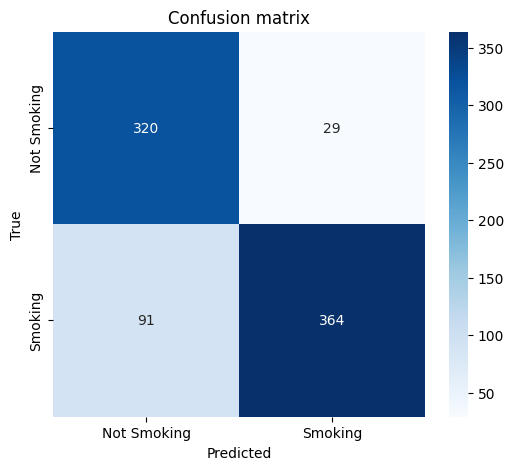

Accuracy: 0.8507
f1: 0.8585
Precision: 0.9262
Sensitivity (Recall): 0.8000


In [ ]:
plot_confusion_mat("Confusion matrix",model1)

## model 2 : using dropout and BatchNormalization (8.55 MB) (f1-score: 0.89)

In [ ]:
drive.mount('/content/drive')

model2 = load_model('/content/drive/My Drive/models/smoker-detection-2.keras')

model2.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 256, 256, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,720,261 (25.64 MB)

 Trainable params: 2,239,937 (8.54 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 4,479,876 (17.09 MB)

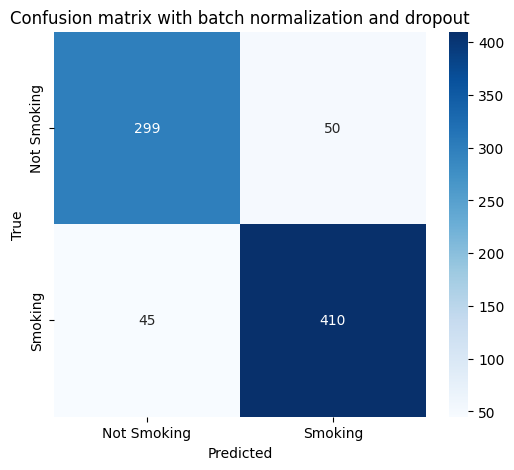

Accuracy: 0.8818
f1: 0.8962
Precision: 0.8913
Sensitivity (Recall): 0.9011


In [ ]:
plot_confusion_mat("Confusion matrix with batch normalization and dropout",model2)

## model 3 : using pre trained model (EfficientNetB0) (16.07 MB) (f1-score: 0.92)

In [28]:
from tensorflow.keras.applications import EfficientNetB0

drive.mount('/content/drive')

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (256, 256)
BATCH = 64


IMG_SIZE = (256, 256)

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)                 # keep 0..255
    label = tf.cast(label, tf.int32)
    return img, label

train_paths_t = tf.constant(train_paths)
train_labels_t = tf.constant(train_labels, dtype=tf.int32)
test_paths_t = tf.constant(test_paths)
test_labels_t = tf.constant(test_labels, dtype=tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths_t, train_labels_t))
train_ds = train_ds.shuffle(buffer_size=len(train_paths)).map(decode_and_resize, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((test_paths_t, test_labels_t))
val_ds = val_ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)



base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(256,256,3))
base_model.trainable = False  # freeze backbone initially

model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])
model3.summary()
model3.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model3.fit(train_ds, validation_data=val_ds, epochs=35,verbose=1)

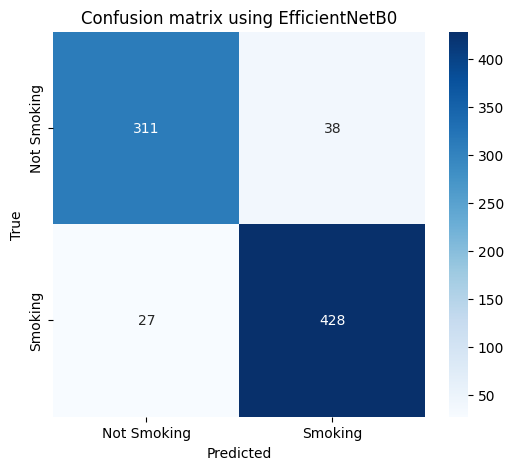

Accuracy: 0.9192
f1: 0.9294
Precision: 0.9185
Sensitivity (Recall): 0.9407


In [31]:
plot_confusion_mat("Confusion matrix using EfficientNetB0",model3)

In [ ]:
def plot_confusion_mat(title,model):
    import seaborn as sns
    y_true = []
    y_pred = []

    for imgs, labs in val_ds:
        preds = model.predict(imgs, verbose=0)
        preds = (preds>= 0.5).astype(int)
        y_true.extend(labs.numpy())
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    #plt.savefig('images/'+title+'.png')
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # If your classes are 0=not_smoking, 1=smoking
    class_names = ["Not Smoking", "Smoking"]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=class_names,yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()
    print(f'Accuracy: {accuracy:.4f}')
    print(f'f1: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')

In [36]:
class_names = ["Not Smoker", "Smoker"]
y_true = []
y_pred = []
for imgs, labs in val_ds:
    preds = model3.predict(imgs, verbose=0)
    preds = (preds>= 0.5).astype(int)
    y_true.extend(labs.numpy())
    y_pred.extend(preds)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
all_images = []
all_labels = []

for imgs, labs in val_ds:
    all_images.extend(imgs.numpy())
    all_labels.extend(labs.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

/tmp/ipython-input-4067210562.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(y_pred[idx] >= 0.5)


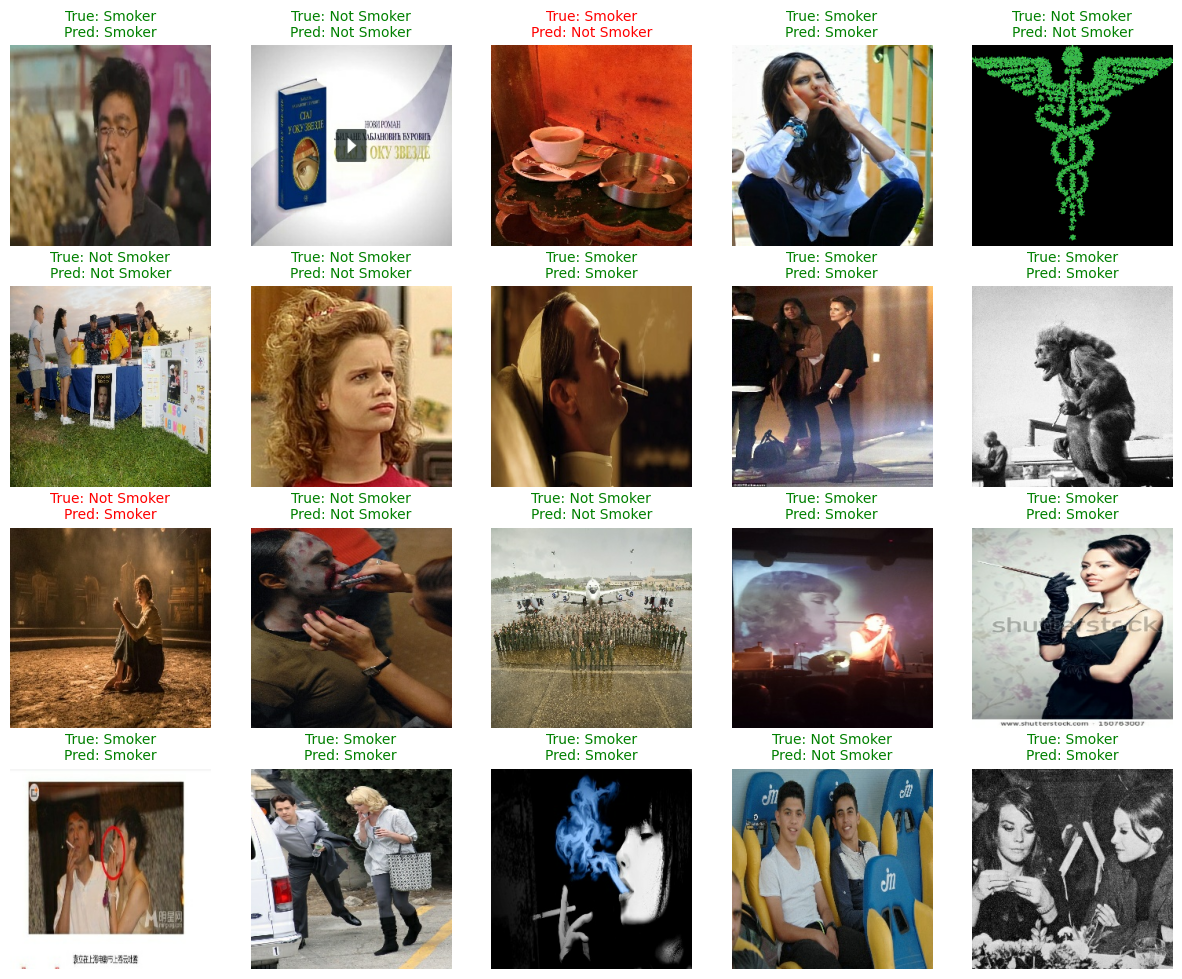

In [38]:


random_indices = random.sample(range(len(y_pred)), 20)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(random_indices):
    img = all_images[idx]
    true_label = all_labels[idx]
    pred_label = int(y_pred[idx] >= 0.5)

    plt.subplot(4, 5, i+1)
    plt.imshow(img/255)
    plt.axis("off")
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
              fontsize=10, color=("green" if true_label==pred_label else "red"))

plt.show()
